In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from pylab import show, figure
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()


In [2]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally 
# takes more than one argument the 'extra_arguments' variable needs to be defined as a tuple 
# (hence (3,) instead of (3)).
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def difference_from_mean_elevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    keys = gh_nodes
    for i in keys:
        area_grid_copy = np.copy(area_grid)
        corresponding_grid_cell = np.isin(gn, i).astype(bool)
        area_grid_copy[~corresponding_grid_cell] = np.nan
        area = np.unique(area_grid_copy[~np.isnan(area_grid_copy)])[0]
        area_dict[i] = area
    return area_dict

In [3]:
input_DEM_resolution = 1
location = (r'C:\PhD\manuscript\flow_routing_algorithms\data')
os.chdir(location)
input_geotiff = gdal.Open('fann_2013_1m.tif')
ig = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
#input_DEM = scipy.ndimage.zoom(x, input_DEM_resolution / initial_resolution, order = 1)
input_DEM = ig
gully_head_layer = gdal.Open('core_nodes_1m.tif')
gh = np.array(gully_head_layer.GetRasterBand(1).ReadAsArray()).astype('uint8')


flow_acc_surf = np.copy(input_DEM).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

grid_nodes = np.array(mg.nodes.reshape(mg.shape));

find_nodes = np.multiply(gh, grid_nodes);

gh_array = np.unique(find_nodes);

gh_list = gh_array.tolist();
gh_list.remove(0);

catchment_area_dict = {}
catchment_area_node_list = []
distance_from_node = 5
contributing_fraction = 0.9

for i in gh_list:
    print(i)
    current_node = i
    result = np.where(grid_nodes == current_node)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Set a distance from the node to define the size of the subset taken (size of subset will be twice plus 1)
    
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # centraL grid node of the subset.
    subset_row_top = int(row_index - distance_from_node)
    subset_row_bot = int(row_index + distance_from_node) + 1
    subset_col_left = int(col_index - distance_from_node)
    subset_col_right = int(col_index + distance_from_node) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    dem_subset_copy = np.copy(input_DEM);
    dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]
    #################################################################################################
    # Find the latitude and longitude index positions of the gully head node in the subset DEM.
    node_lat = distance_from_node + offset_row_top
    node_lon = distance_from_node + offset_col_left
    #################################################################################################  
    # Run M8 for the subset DEM.
    flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
    
    rows_sub = flow_acc_surf_sub.shape[0];
    cols_sub = flow_acc_surf_sub.shape[1];
    mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
    z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
    
    sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
    sfb.run_one_step();
    fa = FlowAccumulator(mg1,
                        surface = 'topographic__elevation',
                        flow_director = 'FlowDirectorMFD',
                        diagonals = True);
    
    fa.run_one_step()
    fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
    fd.run_one_step()
    #################################################################################################
    # Extract required grid properties
    da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
    frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
    drainage_area = da.reshape(mg1.shape);
    frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
    flow_rec_surf_rows = cols_sub * rows_sub;
    flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
    all_receiver_proportions = np.copy(frp);
    grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
    #################################################################################################
    central_node = grid_nodes_sub[node_lat, node_lon]
    # Specific the size of the area to be checked. This represents a physical distance from the 
    # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
    
    # This value is used to initialise the search.
    catchment_outlet_id = central_node
    
    # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
    # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
    # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.
    
    # Create a grid of node value sfor the subset DEM.
    node_location = mg1.nodes.reshape(da.shape);
    for j in range(0, distance_from_node):
        # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
        if j == 0:
            candidate_gridcell = catchment_outlet_id;
        else:
            candidate_gridcell = next_cell_downstream;
        # Get all receiver nodes of the current node.
        grid_cell_receiver_nodes = frp[candidate_gridcell,:];
        # Check if there is a node that receiving >= 'contributing_fraction' from the current node.
        if np.amax(grid_cell_receiver_nodes) < contributing_fraction:
            # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
            # is no suitable grid cell (node).
            if j == distance_from_node - 1:
                catchment_area_dict[i] = 'No grid cell found'
            else:
                # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                # in the next iteration.
                index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0]
                next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
        else:
            # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
            # and record the node ID.
            final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
            final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
            # Find the offest between the index position of the node the loop ends on, and the index position of
            # the node that it started on. 
            final_lat_offset = final_node_index_lat - node_lat
            final_lon_offset = final_node_index_lon - node_lon
            # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
            # node ID of the grid cell that met the criteria above.
            final_row_index = row_index + final_lat_offset
            final_col_index = col_index + final_lon_offset
            node_of_area_record = grid_nodes[final_row_index, final_col_index]
            catchment_area_dict[i] = node_of_area_record
            catchment_area_node_list.append(node_of_area_record)
            break
            
outlet_ids = np.isin(grid_nodes,catchment_area_node_list).astype('uint8')




8000074
9194578
9316061
9956490
10228251
10520704
10772882
10966975
11216606
11435779
11446962
11489783
11511019
11957039
12023549
12315281
12370422
12491192
13077265
13097729
13130326
13401726
13490070
13773468
13792280
13839467
14239845
14261597
14546211
14608281
14837310
14989581
15879809
15894073
16010609
16272532
16338607
16587137
16762758
16793232
16814038
16838910
16945936
16991053
17694880
17760983
17826221
17935679
18065963
18534260
18546191
18597374
18673441
18686432
18858777
18945767
19120290
19274272
19609482
19753146
19795416
19826063
19839697
20122465
20228376
20252738
20361473
20436184
20447040
20499944
20575807
20610132
20632600
21056149
21795400
21915575
22198075
22491653
22719474
22741206
22773002
22839044
23466949
24111460
24159100
24293839
24318338
24343914
24413437
24419566
24579387
24623073
24803792
24901645
24940950
24978578
25002647
25265114
25358178
25450033
25616063
25859900
26241448
26343725
26515067
26708388
27184158
27188923
27409824
27586421
27794584
27904

In [4]:
len(catchment_area_node_list)

260

In [302]:
outlet_ids

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [5]:
input_geotiff = gdal.Open('fann_D4_1m.tif')
D4 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_D8_1m.tif')
D8 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_Dinf_1m.tif')
Dinf = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_M4_1m.tif')
M4 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

input_geotiff = gdal.Open('fann_M8_1m.tif')
M8 = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())

In [6]:
D4_dict = catchmentDicts(D4, grid_nodes, catchment_area_node_list)
D8_dict = catchmentDicts(D8, grid_nodes, catchment_area_node_list)
Dinf_dict = catchmentDicts(Dinf, grid_nodes, catchment_area_node_list)
M4_dict = catchmentDicts(M4, grid_nodes, catchment_area_node_list)
M8_dict = catchmentDicts(M8, grid_nodes, catchment_area_node_list)


In [7]:
ds = [D4_dict, D8_dict, Dinf_dict, M4_dict, M8_dict]
d = {}
for k in D4_dict.keys():
    d[k] = tuple(d[k] for d in ds)

In [8]:
catchment_areas_1m_divergent = pd.DataFrame.from_dict(d, orient='index')
catchment_areas_1m_divergent.rename(columns={0: 'D4', 1: 'D8', 2: 'Dinf', 3: 'M4', 4: 'M8'}, inplace=True)
node_id_column = np.array(catchment_areas_1m_divergent.index)
catchment_areas_1m_divergent['node_id'] = node_id_column


In [9]:
catchment_areas_1m_divergent.head()

,D4,D8,Dinf,M4,M8,node_id
8000074,0.5183,0.9929,1.024181,0.900704,0.962416,8000074
9172835,0.2330,0.7025,0.673875,0.676058,0.665612,9172835
9370420,1.2351,1.2773,0.801749,1.262353,0.812412,9370420
9956490,0.5578,0.4186,0.420061,0.436668,0.426981,9956490
10217375,1.1357,0.7424,0.774059,0.437948,0.562779,10217375


In [10]:
catchment_areas_1m_divergent.to_csv(r'C:/PhD/junk/catchment_areas_1m_divergent_10m.csv', index = False, header=True)

In [323]:
corr_5m_divergent = catchment_areas_5m_divergent.corr()

In [782]:
catchment_areas_1m_convergent

,D4,D8,Dinf,M4,M8,Shape
6369407,0.7936,0.4192,0.432222,0.584626,0.481259,Convergent
8402506,0.5654,0.5344,0.504951,0.546750,0.482315,Convergent
9130277,0.8072,0.7289,0.728331,0.757537,0.464273,Convergent
9183765,0.4843,0.8293,0.723900,0.759752,0.470430,Convergent
9370132,0.1874,0.2118,0.219679,0.261214,0.262989,Convergent
...,...,...,...,...,...,...
59870384,0.8688,0.8039,0.945910,0.947341,0.835022,Convergent
61933545,2.7846,3.2601,3.191167,2.247934,1.849341,Convergent
62075038,2.4527,4.7473,4.806600,4.606624,2.758960,Convergent
62794131,0.0023,22.0751,22.088686,10.974792,15.353873,Convergent


In [367]:
catchment_areas_1m_divergent['Shape'] = 'Divergent'
catchment_areas_1m_convergent['Shape'] = 'Convergent'
catchment_areas_2m_divergent['Shape'] = 'Divergent'
catchment_areas_2m_convergent['Shape'] = 'Convergent'
catchment_areas_3m_divergent['Shape'] = 'Divergent'
catchment_areas_3m_convergent['Shape'] = 'Convergent'
catchment_areas_4m_divergent['Shape'] = 'Divergent'
catchment_areas_4m_convergent['Shape'] = 'Convergent'
catchment_areas_5m_divergent['Shape'] = 'Divergent'
catchment_areas_5m_convergent['Shape'] = 'Convergent'

In [368]:
area_data = pd.concat([catchment_areas_1m_divergent,catchment_areas_2m_convergent,
                      catchment_areas_2m_divergent,catchment_areas_2m_convergent,
                      catchment_areas_3m_divergent,catchment_areas_3m_convergent,
                      catchment_areas_4m_divergent,catchment_areas_4m_convergent,
                      catchment_areas_5m_divergent,catchment_areas_5m_convergent])

In [369]:
area_data

,D4,D8,Dinf,M4,M8,node_id,Shape
8000074,0.5183,0.9929,1.024181,0.900704,0.962416,8000074,Divergent
9172835,0.2330,0.7025,0.673875,0.676058,0.665612,9172835,Divergent
9956490,0.5578,0.4186,0.420061,0.436668,0.426981,9956490,Divergent
10217375,1.1357,0.7424,0.774059,0.437948,0.562779,10217375,Divergent
10498956,0.4231,0.5060,0.430575,0.390651,0.231377,10498956,Divergent
...,...,...,...,...,...,...,...
2212468,1.2275,0.7875,0.839356,0.867697,0.828910,2212468,Convergent
2395404,0.9100,0.0575,0.358584,0.993850,0.518185,2395404,Convergent
2477512,5.0700,3.1275,4.247647,3.211978,3.910798,2477512,Convergent
2481891,2.0775,4.7825,4.808707,2.150892,3.071859,2481891,Convergent


In [370]:
a = area_data[['D4', 'Shape']]
b = area_data[['D8', 'Shape']]
c = area_data[['Dinf', 'Shape']]
d = area_data[['M4', 'Shape']]
e = area_data[['M8', 'Shape']]

In [371]:
a['Method'] = 'D4'
b['Method'] = 'D8'
c['Method'] = 'Dinf'
d['Method'] = 'M4'
e['Method'] = 'M8'

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [372]:
A = a.rename(columns={'D4':'Area'})
B = b.rename(columns={'D8':'Area'})
C = c.rename(columns={'Dinf':'Area'})
D = d.rename(columns={'M4':'Area'})
E = e.rename(columns={'M8':'Area'})

In [373]:
area_data = pd.concat([A,B,C,D,E])

In [374]:
area_data

,Area,Shape,Method
8000074,0.518300,Divergent,D4
9172835,0.233000,Divergent,D4
9956490,0.557800,Divergent,D4
10217375,1.135700,Divergent,D4
10498956,0.423100,Divergent,D4
...,...,...,...
2212468,0.828910,Convergent,M8
2395404,0.518185,Convergent,M8
2477512,3.910798,Convergent,M8
2481891,3.071859,Convergent,M8


In [333]:
area_data_reformat

NameError: name 'area_data_reformat' is not defined

(-1, 4)

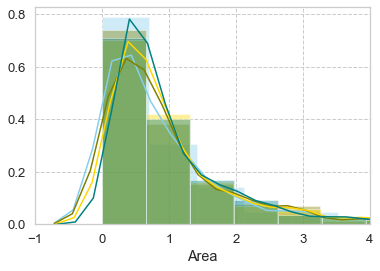

In [713]:

plot = sns.distplot( A["Area"] , color="skyblue")
plot = sns.distplot( B["Area"] , color="olive")
plot = sns.distplot( C["Area"] , color="gold")
plot = sns.distplot( D["Area"] , color="teal")
plot.set_xlim(-1, 4)

[None, None]

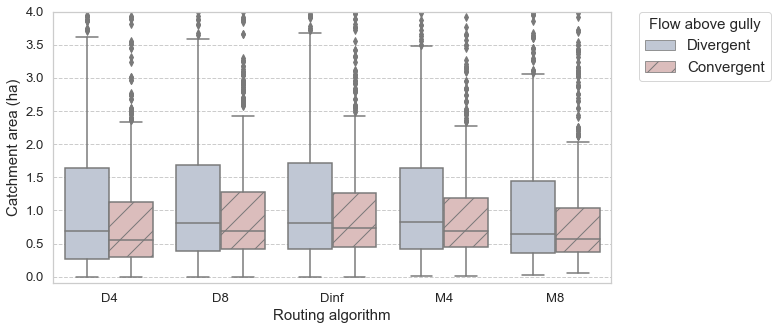

In [375]:
# Plot miles per gallon against horsepower with other semantics
sns.set(font_scale = 1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

fig, ax = plt.subplots(figsize = (10, 5))
g = sns.boxplot(x="Method", y="Area", palette="vlag", hue = 'Shape', data=area_data)

ax.set_ylabel('Catchment area (ha)', fontsize = 15)
ax.set_xlabel('Routing algorithm', fontsize = 15)
ax.set_ylim(-0.1, 4)
#plt.title('Partitioning behaviour between adjacent gully heads', fontsize = 20)

hatches = ["", "/", "",  "/", "",  "/", "",  "/", "", "/"]
for hatch, patch in zip(hatches, g.artists):
    patch.set_hatch(hatch)
    
hatches = ["", "/"]

# Loop over the bars
for i,thisbar in enumerate(g.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Flow above gully',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title


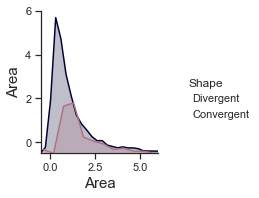

In [377]:

sns.set(style = "ticks")
colors = ["xkcd:very dark blue", "xkcd:mauve"]

def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color = 'xkcd:merlot', marker=None,
            linestyle='--', linewidth=1.0)

g = sns.pairplot(area_data, palette = colors, hue = 'Shape', markers=['x', 'o'])

sns.plotting_context()
g.map_offdiag(plot_unity)

g.set(ylim=(-0.5,6))
g.set(xlim=(-0.5,6))
plt.rcParams["axes.labelsize"] = 15
for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    m = ax.get_ylabel()
    ax.set_xlabel(l, fontsize=15)
    ax.set_ylabel(m, fontsize=15)

(-0.1, 2)

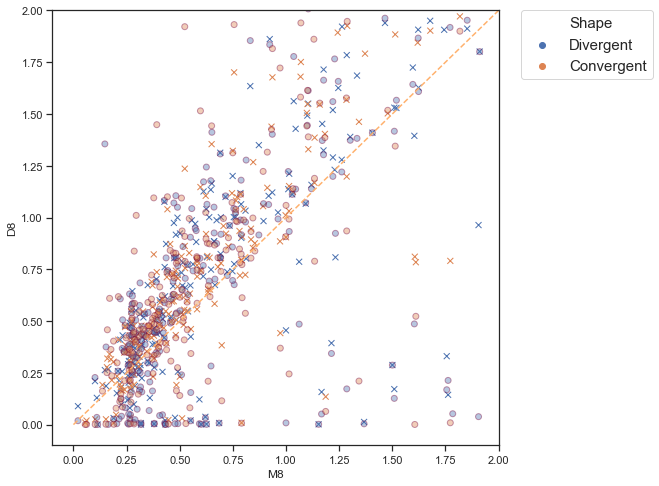

In [388]:
fig, ax = plt.subplots(figsize = (8, 8))
data = area_data
g0 = sns.scatterplot(x="M8", y="Dinf", marker = 'x', edgecolor= 'xkcd:royal blue', legend = False, 
                     linewidth = 1,data=data, hue = 'Shape')
g1 = sns.scatterplot(x="M8", y="D8", alpha=0.4, color='xkcd:merlot', edgecolor= 'xkcd:merlot', 
                      linewidth = 1, data=data, hue = 'Shape')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = '',fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:apricot')
ax.set_ylim(-0.1,2)
ax.set_xlim(-0.1,2)

In [727]:
sns.set_style('ticks', {'grid.linestyle': '--'})

colours = {'Convergent':'xkcd:mid blue', 'Divergent':'xkcd:pale pink'}
x_axis = 'M8'
y_axis = 'M4'
g = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'Shape',
                 data=area_data, alpha = 0.7, legend = 'brief', edgecolor="k", style = 'Shape')

ax = g.axes[0,0]
ax.set_xlim(-0.1,6)
ax.set_ylim(-0.1,6)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = g._legend
plt.rcParams["axes.edgecolor"] = "0.15"
plt.plot([0, 10], [0, 10], linestyle='--', color = 'xkcd:chocolate', alpha = 0.5)

ValueError: Could not interpret input 'M8'

In [635]:
corr_5m_divergent

,D4,D8,Dinf,M4,M8
D4,1.000000,0.540476,0.536053,0.918756,0.530049
D8,0.540476,1.000000,0.911875,0.695436,0.748933
Dinf,0.536053,0.911875,1.000000,0.747559,0.932911
M4,0.918756,0.695436,0.747559,1.000000,0.748790
M8,0.530049,0.748933,0.932911,0.748790,1.000000


[Text(0, 0.5, 'D4'),
 Text(0, 1.5, 'D8'),
 Text(0, 2.5, 'Dinf'),
 Text(0, 3.5, 'M4'),
 Text(0, 4.5, 'M8')]

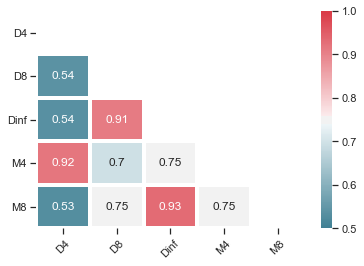

In [620]:
sns.set(style = 'ticks')

data = corr_5m_divergent

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=data.columns, mask=mask,
                         yticklabels=data.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.5, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [334]:
correlation_dict_convergent = {}

In [335]:
#correlation_dict['D4/D8'] = [c.iloc[1,0], c_2m.iloc[1,0], c_3m.iloc[1,0], c_4m.iloc[1,0], c_5m.iloc[1,0]]
#correlation_dict['D4/Dinf'] = [c.iloc[2,0], c_2m.iloc[2,0], c_3m.iloc[2,0], c_4m.iloc[2,0], c_5m.iloc[2,0]]
#correlation_dict['D4/M4'] = [c.iloc[3,0], c_2m.iloc[3,0], c_3m.iloc[3,0], c_4m.iloc[3,0], c_5m.iloc[3,0]]
correlation_dict_convergent['D4/M8'] = [corr_1m_convergent.iloc[4,0], 
                             corr_2m_convergent.iloc[4,0], corr_3m_convergent.iloc[4,0], 
                             corr_4m_convergent.iloc[4,0], corr_5m_convergent.iloc[4,0]]
#correlation_dict['D8/Dinf'] = [c.iloc[2,1], c_2m.iloc[2,1], c_3m.iloc[2,1], c_4m.iloc[2,1], c_5m.iloc[2,1]]
#correlation_dict['D8/M4'] = [c.iloc[3,1], c_2m.iloc[3,1], c_3m.iloc[3,1], c_4m.iloc[3,1], c_5m.iloc[3,1]]
correlation_dict_convergent['D8/M8'] = [corr_1m_convergent.iloc[4,1], 
                             corr_2m_convergent.iloc[4,1], corr_3m_convergent.iloc[4,1], 
                             corr_4m_convergent.iloc[4,1], corr_5m_convergent.iloc[4,1]]
#correlation_dict['Dinf/M4'] = [c.iloc[3,2], c_2m.iloc[3,2], c_3m.iloc[3,2], c_4m.iloc[3,2], c_5m.iloc[3,2]]
correlation_dict_convergent['Dinf/M8'] = [corr_1m_convergent.iloc[4,2], 
                               corr_2m_convergent.iloc[4,2], corr_3m_convergent.iloc[4,2], 
                               corr_4m_convergent.iloc[4,2], corr_5m_convergent.iloc[4,2]]
correlation_dict_convergent['M4/M8'] = [corr_1m_convergent.iloc[4,3], 
                             corr_2m_convergent.iloc[4,3], corr_3m_convergent.iloc[4,3], 
                             corr_4m_convergent.iloc[4,3], corr_5m_convergent.iloc[4,3]]

In [336]:
 correlation_convergent_dataframe = pd.DataFrame.from_dict(correlation_dict_convergent, orient='index')

In [337]:
convergent_corr_1m =  correlation_convergent_dataframe.iloc[:,0].to_frame()
convergent_corr_2m =  correlation_convergent_dataframe.iloc[:,1].to_frame()
convergent_corr_3m =  correlation_convergent_dataframe.iloc[:,2].to_frame()
convergent_corr_4m =  correlation_convergent_dataframe.iloc[:,3].to_frame()
convergent_corr_5m =  correlation_convergent_dataframe.iloc[:,4].to_frame()

In [338]:
convergent_corr_1m_rename = convergent_corr_1m.rename(columns={0: "Correlation"})
convergent_corr_2m_rename = convergent_corr_2m.rename(columns={1: "Correlation"})
convergent_corr_3m_rename = convergent_corr_3m.rename(columns={2: "Correlation"})
convergent_corr_4m_rename = convergent_corr_4m.rename(columns={3: "Correlation"})
convergent_corr_5m_rename = convergent_corr_5m.rename(columns={4: "Correlation"})


In [339]:
convergent_corr_1m_rename.insert(1, 'Resolution', True) 
convergent_corr_2m_rename.insert(1, 'Resolution', True) 
convergent_corr_3m_rename.insert(1, 'Resolution', True) 
convergent_corr_4m_rename.insert(1, 'Resolution', True) 
convergent_corr_5m_rename.insert(1, 'Resolution', True) 

In [340]:
convergent_corr_1m_rename.insert(2, "Method", ['D4/M8', 'D8/M8', 'Dinf/M8','M4/M8'], True)  
convergent_corr_2m_rename.insert(2, "Method", ['D4/M8', 'D8/M8', 'Dinf/M8','M4/M8'], True)  
convergent_corr_3m_rename.insert(2, "Method", ['D4/M8', 'D8/M8', 'Dinf/M8','M4/M8'], True)  
convergent_corr_4m_rename.insert(2, "Method", ['D4/M8', 'D8/M8', 'Dinf/M8','M4/M8'], True) 
convergent_corr_5m_rename.insert(2, "Method", ['D4/M8', 'D8/M8', 'Dinf/M8','M4/M8'], True)

#corr_1m_rename.insert(2, "Method", ['D4/D8','D4/Dinf', 'D4/M4', 
#                                           'D4/M8', 'D8/Dinf', 'D8/M4', 'D8/M8', 'Dinf/M4', 'Dinf/M8','M4/M8'], True) 
#corr_2m_rename.insert(2, "Method", ['D4/D8','D4/Dinf', 'D4/M4', 
#                                           'D4/M8', 'D8/Dinf', 'D8/M4', 'D8/M8', 'Dinf/M4', 'Dinf/M8','M4/M8'], True) 
#corr_3m_rename.insert(2, "Method", ['D4/D8','D4/Dinf', 'D4/M4', 
#                                           'D4/M8', 'D8/Dinf', 'D8/M4', 'D8/M8', 'Dinf/M4', 'Dinf/M8','M4/M8'], True) 
#corr_4m_rename.insert(2, "Method", ['D4/D8','D4/Dinf', 'D4/M4', 
#                                           'D4/M8', 'D8/Dinf', 'D8/M4', 'D8/M8', 'Dinf/M4', 'Dinf/M8','M4/M8'], True) 
#corr_5m_rename.insert(2, "Method", ['D4/D8','D4/Dinf', 'D4/M4', 
#                                           'D4/M8', 'D8/Dinf', 'D8/M4', 'D8/M8', 'Dinf/M4', 'Dinf/M8','M4/M8'], True) 


convergent_corr_1m_rename['Resolution'] = '1m'
convergent_corr_2m_rename['Resolution'] = '2m'
convergent_corr_3m_rename['Resolution'] = '3m'
convergent_corr_4m_rename['Resolution'] = '4m'
convergent_corr_5m_rename['Resolution'] = '5m'

In [341]:
convergent_combined_correlations = convergent_corr_1m_rename.append([convergent_corr_2m_rename, 
                                                                   convergent_corr_3m_rename,
                                                                   convergent_corr_4m_rename,
                                                                   convergent_corr_5m_rename])

In [634]:
convergent_combined_correlations

,Correlation,Resolution,Method
D4/M8,0.818340,1m,D4/M8
D8/M8,0.980918,1m,D8/M8
Dinf/M8,0.985139,1m,Dinf/M8
M4/M8,0.920371,1m,M4/M8
D4/M8,0.910630,2m,D4/M8
D8/M8,0.952174,2m,D8/M8
Dinf/M8,0.962722,2m,Dinf/M8
M4/M8,0.979138,2m,M4/M8
D4/M8,0.917787,3m,D4/M8
D8/M8,0.965819,3m,D8/M8


[None, None]

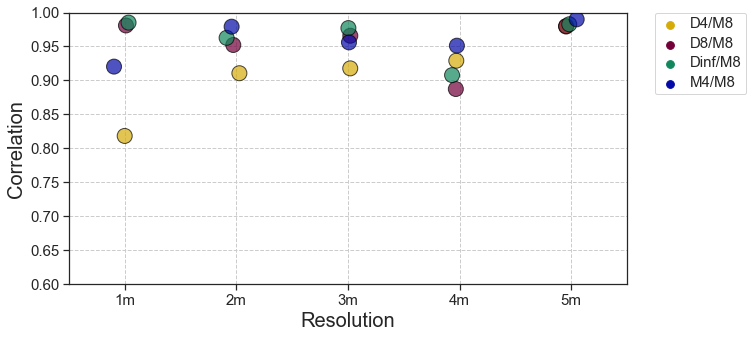

In [342]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (10, 5))
data = convergent_combined_correlations
colours = {'D4/M8':'xkcd:burnt yellow', 'D8/M8':'xkcd:merlot', 'Dinf/M8':'xkcd:dark sea green', 'M4/M8':'xkcd:cobalt blue'}
g = sns.stripplot(x = 'Resolution', y = 'Correlation', hue = 'Method',size=15, marker="o",
                   edgecolor="black", alpha=.7, palette = colours,
             data=data,  linewidth=1)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(ylim = (0.6, 1))
#for ind, label in enumerate(g.get_xticklabels()):
#    if ind % 2 == 0:  # every 10th label is kept
#        label.set_visible(False)
#    else:
#        label.set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

In [343]:
from matplotlib.lines import Line2D


In [1]:
sns.set(style = 'ticks')
fig, ax = plt.subplots(figsize = (10, 6))
jitter = 0.15
data = convergent_combined_correlations
ylim_min = .6
ylim_max = 1
#plt.clf()
D4p = data[(data['Method']=='D4/M8')]
colors = ['burnt yellow']
m = sns.stripplot('Resolution','Correlation',hue='Method',
                  marker='o',data=D4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)
m.set(ylim = (ylim_min, ylim_max))
D8p = data[(data['Method']=='D8/M8')]
colors = ['merlot']
n = sns.stripplot('Resolution','Correlation',hue='Method',
                  marker='v',data=D8p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

Dinfp = data[(data['Method']=='Dinf/M8')]
colors = ['dark sea green']
o = sns.stripplot('Resolution','Correlation',hue='Method',
                  marker='s',data=Dinfp, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

M4p = data[(data['Method']=='M4/M8')]
colors = ['cobalt blue']
p = sns.stripplot('Resolution','Correlation',hue='Method',
                  marker='D',data=M4p, jitter=jitter, 
                  palette=sns.xkcd_palette(colors),
                  split=True,linewidth=2,edgecolor="black", size = 15, alpha = 0.7)

plt.grid(linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(ylim = (ylim_min, ylim_max))
ax.set_xlabel('Resolution', fontsize = 15)
ax.set_ylabel('Correlation', fontsize = 15)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='22') # for legend title

D4l = Line2D([], [], color='xkcd:burnt yellow', marker='o', linestyle='None',
                          markersize=15, label='D4-M8')
D8l = Line2D([], [], color='xkcd:merlot', marker='v', linestyle='None',
                          markersize=15, label='D8-M8')
Dinfl = Line2D([], [], color='xkcd:dark sea green', marker='s', linestyle='None',
                          markersize=15, label='Dinf-M8')
M4l = Line2D([], [], color='xkcd:cobalt blue', marker='D', linestyle='None',
                          markersize=15, label='M4-M8')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Resolution', fontsize = 20)
ax.set_ylabel('Correlation', fontsize = 20)

plt.legend(handles=[D4l, D8l, Dinfl,M4l],fontsize=15)


NameError: name 'sns' is not defined

In [ ]:
data = c_5m

mask = np.triu(np.ones_like(data, dtype=np.bool))

comparison = sns.heatmap(data, xticklabels=c.columns, mask=mask,
                         yticklabels=c.columns, annot = True,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin = 0.8, vmax = 1, linecolor = 'white', linewidths = 3)

comparison.set_xticklabels(comparison.get_xticklabels(), rotation=45)
comparison.set_yticklabels(comparison.get_yticklabels(), rotation=0)

In [ ]:
isolate_catchment_area_nodes = np.isin(grid_nodes, catchment_area_node_list).astype(int)

In [ ]:
np.unique(isolate_catchment_area_nodes)

In [ ]:
plt.imshow(isolate_catchment_area_nodes, cmap="terrain");
plt.colorbar();

In [38]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [50]:
np_array_to_Geotiff('conv_ids_1m_adj_10m.tif', input_geotiff, outlet_ids, input_DEM.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
